In [2]:
pwd = "/scratch/ty296/"
hdf5_data_path = '/scratch/ty296/hdf5_data/'
groupname = 'L'
p_fixed_name = 'p_ctrl'
p_fixed_value = 0.4
import os
print(os.getcwd())
import sys
sys.path.append('/scratch/ty296/CT_MPS_mini')
import h5py
import numpy as np

/scratch/ty296


In [3]:
# View singular values from your HDF5 file
filename = os.path.join(pwd, "hdf5_data_combined/sv_combined_p_ctrl0.0.h5")
real_num = 0
with h5py.File(filename, 'r') as f:
    # Get the first key to examine
    first_key = list(f.keys())[real_num]
    print(f"Examining key: {first_key}")
    
    # Get the singular values array
    sv_array = f[first_key][()]
    
    # Display basic info
    print(f"Shape: {sv_array.shape}")
    print(f"Data type: {sv_array.dtype}")
    print(f"Number of singular values: {len(sv_array)}")
    
    # Display the actual values
    print(f"\nSingular values:")
    print(sv_array)
    
    # Display metadata
    print(f"\nMetadata:")
    for attr_name, attr_value in f[first_key].attrs.items():
        print(f"  {attr_name}: {attr_value}")


Examining key: real1
Shape: (1024,)
Data type: float64
Number of singular values: 1024

Singular values:
[6.23137332e-02 6.16276907e-02 6.14375849e-02 ... 1.48454760e-04
 1.22651931e-04 1.84403662e-05]

Metadata:
  L: 20
  maxbond: 1024
  maxdim: 1024
  n_chunk_realizations: 10
  p_ctrl: 0.0
  p_proj: 0.0


In [4]:
with h5py.File(filename, 'r') as f:
    L_target = 24
    matching_groups = []
    
    print(f"Searching for groups with L={L_target}...")
    print("=" * 80)
    
    # Loop through all realizations
    for key in f.keys():
        # Check if this group has L=24
        if 'L' in f[key].attrs and f[key].attrs['L'] == L_target:
            matching_groups.append(key)
    
    print(f"Found {len(matching_groups)} groups with L={L_target}")
    print()
    
    # # Display information for each matching group
    # for i, key in enumerate(matching_groups):
    #     sv_array = f[key][()]
    #     attrs = dict(f[key].attrs)
        
    #     print(f"Group {i+1}: {key}")
    #     print(f"  L = {attrs.get('L')}")
    #     print(f"  p_ctrl = {attrs.get('p_ctrl')}")
    #     print(f"  p_proj = {attrs.get('p_proj')}")
    #     print(f"  maxbond = {attrs.get('maxbond')}")
    #     print(f"  Singular value array shape: {sv_array.shape}")
    #     print(f"  Singular values: {sv_array}")
    #     print(f"  Max SV: {np.max(sv_array):.6e}")
    #     print(f"  Min SV: {np.min(sv_array):.6e}")
    #     print(f"  Number of SVs: {len(sv_array)}")
    #     print("-" * 60)


Searching for groups with L=24...
Found 42067 groups with L=24



In [5]:
# Plot singular values for all L=24 groups
L24_groups = []

with h5py.File(filename, 'r') as f:
    L_target = 24
    
    # Collect all L=24 groups
    for key in f.keys():
        if 'L' in f[key].attrs and f[key].attrs['L'] == L_target:
            L24_groups.append(key)


In [7]:
for key in L24_groups[:5]:
    with h5py.File(filename, 'r') as f:
        print(f[key].attrs.keys())
        print(f[key].attrs['p_proj'])
        # print(f[key].attrs['seed'])

<KeysViewHDF5 ['L', 'maxbond', 'maxdim', 'n_chunk_realizations', 'p_ctrl', 'p_proj']>
0.2
<KeysViewHDF5 ['L', 'maxbond', 'maxdim', 'n_chunk_realizations', 'p_ctrl', 'p_proj']>
0.2
<KeysViewHDF5 ['L', 'maxbond', 'maxdim', 'n_chunk_realizations', 'p_ctrl', 'p_proj']>
0.2
<KeysViewHDF5 ['L', 'maxbond', 'maxdim', 'n_chunk_realizations', 'p_ctrl', 'p_proj']>
0.2
<KeysViewHDF5 ['L', 'maxbond', 'maxdim', 'n_chunk_realizations', 'p_ctrl', 'p_proj']>
0.2


In [ ]:
# collect all the seed values for L=24 groups
seed_values = []
p_proj_value = None
target_key = L24_groups[10]
with h5py.File(filename, 'r') as f:
    p_proj_value = f[target_key].attrs['p_proj']
print(target_key)
print(p_proj_value)


real100565
0.2


In [10]:
# for key in L24_groups:
#     with h5py.File(filename, 'r') as f:
#         # print(f[key].attrs['p_proj'])
#         if f[key].attrs['p_proj'] == p_proj_value:
#             seed_values.append(f[key].attrs['seed'])
#         else:
#             continue

# unique_seeds = set(seed_values)
# # print(f"Unique seeds: {sorted(unique_seeds)}")
# print(f"Number of unique seeds: {len(unique_seeds)}")


In [11]:
print(len(seed_values))

0


In [12]:
np.linspace(0.2, 1.0, 20)[:10]

array([0.2       , 0.24210526, 0.28421053, 0.32631579, 0.36842105,
       0.41052632, 0.45263158, 0.49473684, 0.53684211, 0.57894737])

In [13]:
np.linspace(0.2, 0.36842105, 5)

array([0.2       , 0.24210526, 0.28421052, 0.32631579, 0.36842105])

In [14]:
from read_hdf5_func import von_neumann_entropy_sv
dict = {}
with h5py.File(filename, 'r') as f:
    for key in L24_groups:
        entropy = von_neumann_entropy_sv(f[key][()], n=0, positivedefinite=False, threshold=1e-15)
        p_proj = f[key].attrs['p_proj']
        if p_proj in dict:
            dict[p_proj].append(entropy)
        else:
            dict[p_proj] = [entropy]
        # print(entropy)
        # print(f[key].attrs['p_proj'])

ModuleNotFoundError: No module named '_ctypes'

In [ ]:
print(len(dict))

21


81
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000


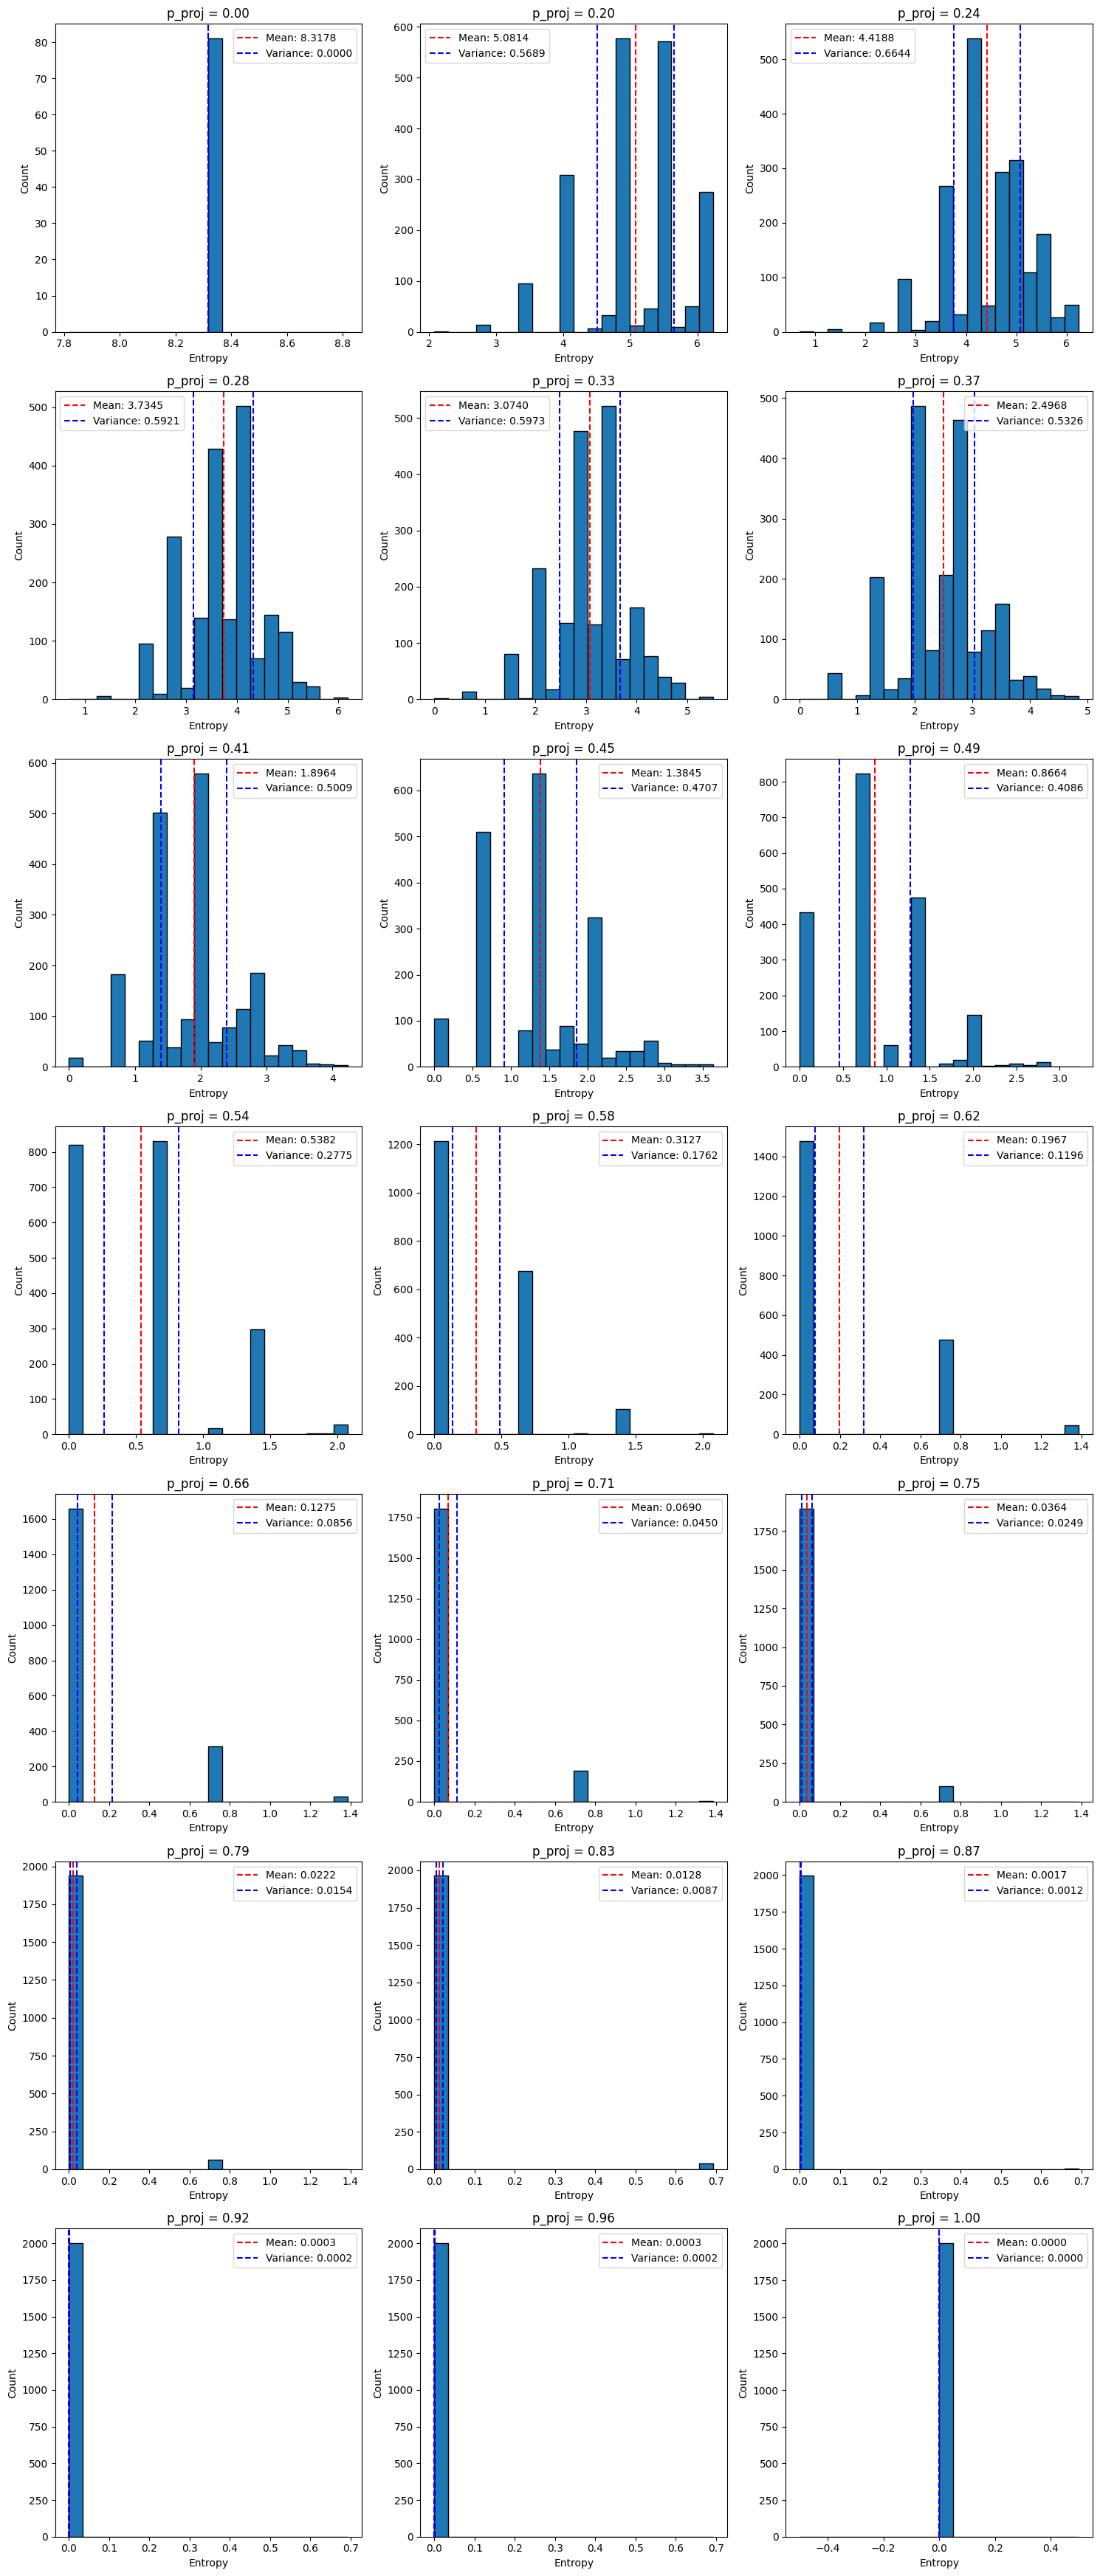

In [ ]:
import matplotlib.pyplot as plt
from read_hdf5_func import calculate_variance_and_error, calculate_mean_and_error

# Create a figure with subplots arranged based on number of p_proj values
n_plots = len(dict)
n_cols = 3
n_rows = (n_plots + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
axes = axes.flatten()

# Plot histogram for each p_proj value
for idx, (p_proj, entropies) in enumerate(sorted(dict.items())):
    ax = axes[idx]
    mean, sem = calculate_mean_and_error(entropies)
    var, semvar = calculate_variance_and_error(entropies)
    print(len(entropies))
    ax.hist(entropies, bins=20, edgecolor='black')
    ax.set_title(f'p_proj = {p_proj:.2f}')
    ax.set_xlabel('Entropy')
    ax.set_ylabel('Count')
    ax.axvline(mean, color='red', linestyle='--', label=f'Mean: {mean:.4f}')
    ax.axvline(mean + var, color='blue', linestyle='--', label=f'Variance: {var:.4f}')
    ax.axvline(mean - var, color='blue', linestyle='--')
    ax.legend()

# Remove any empty subplots
for idx in range(len(dict), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()


In [ ]:
dict_maxbond = {}
with h5py.File(filename, 'r') as f:
    for key in L24_groups:
        maxbond = f[key].attrs['maxbond']
        p_proj = f[key].attrs['p_proj']
        if p_proj in dict_maxbond:
            dict_maxbond[p_proj].append(maxbond)
        else:
            dict_maxbond[p_proj] = [maxbond]
        # print(entropy)
        # print(f[key].attrs['p_proj'])

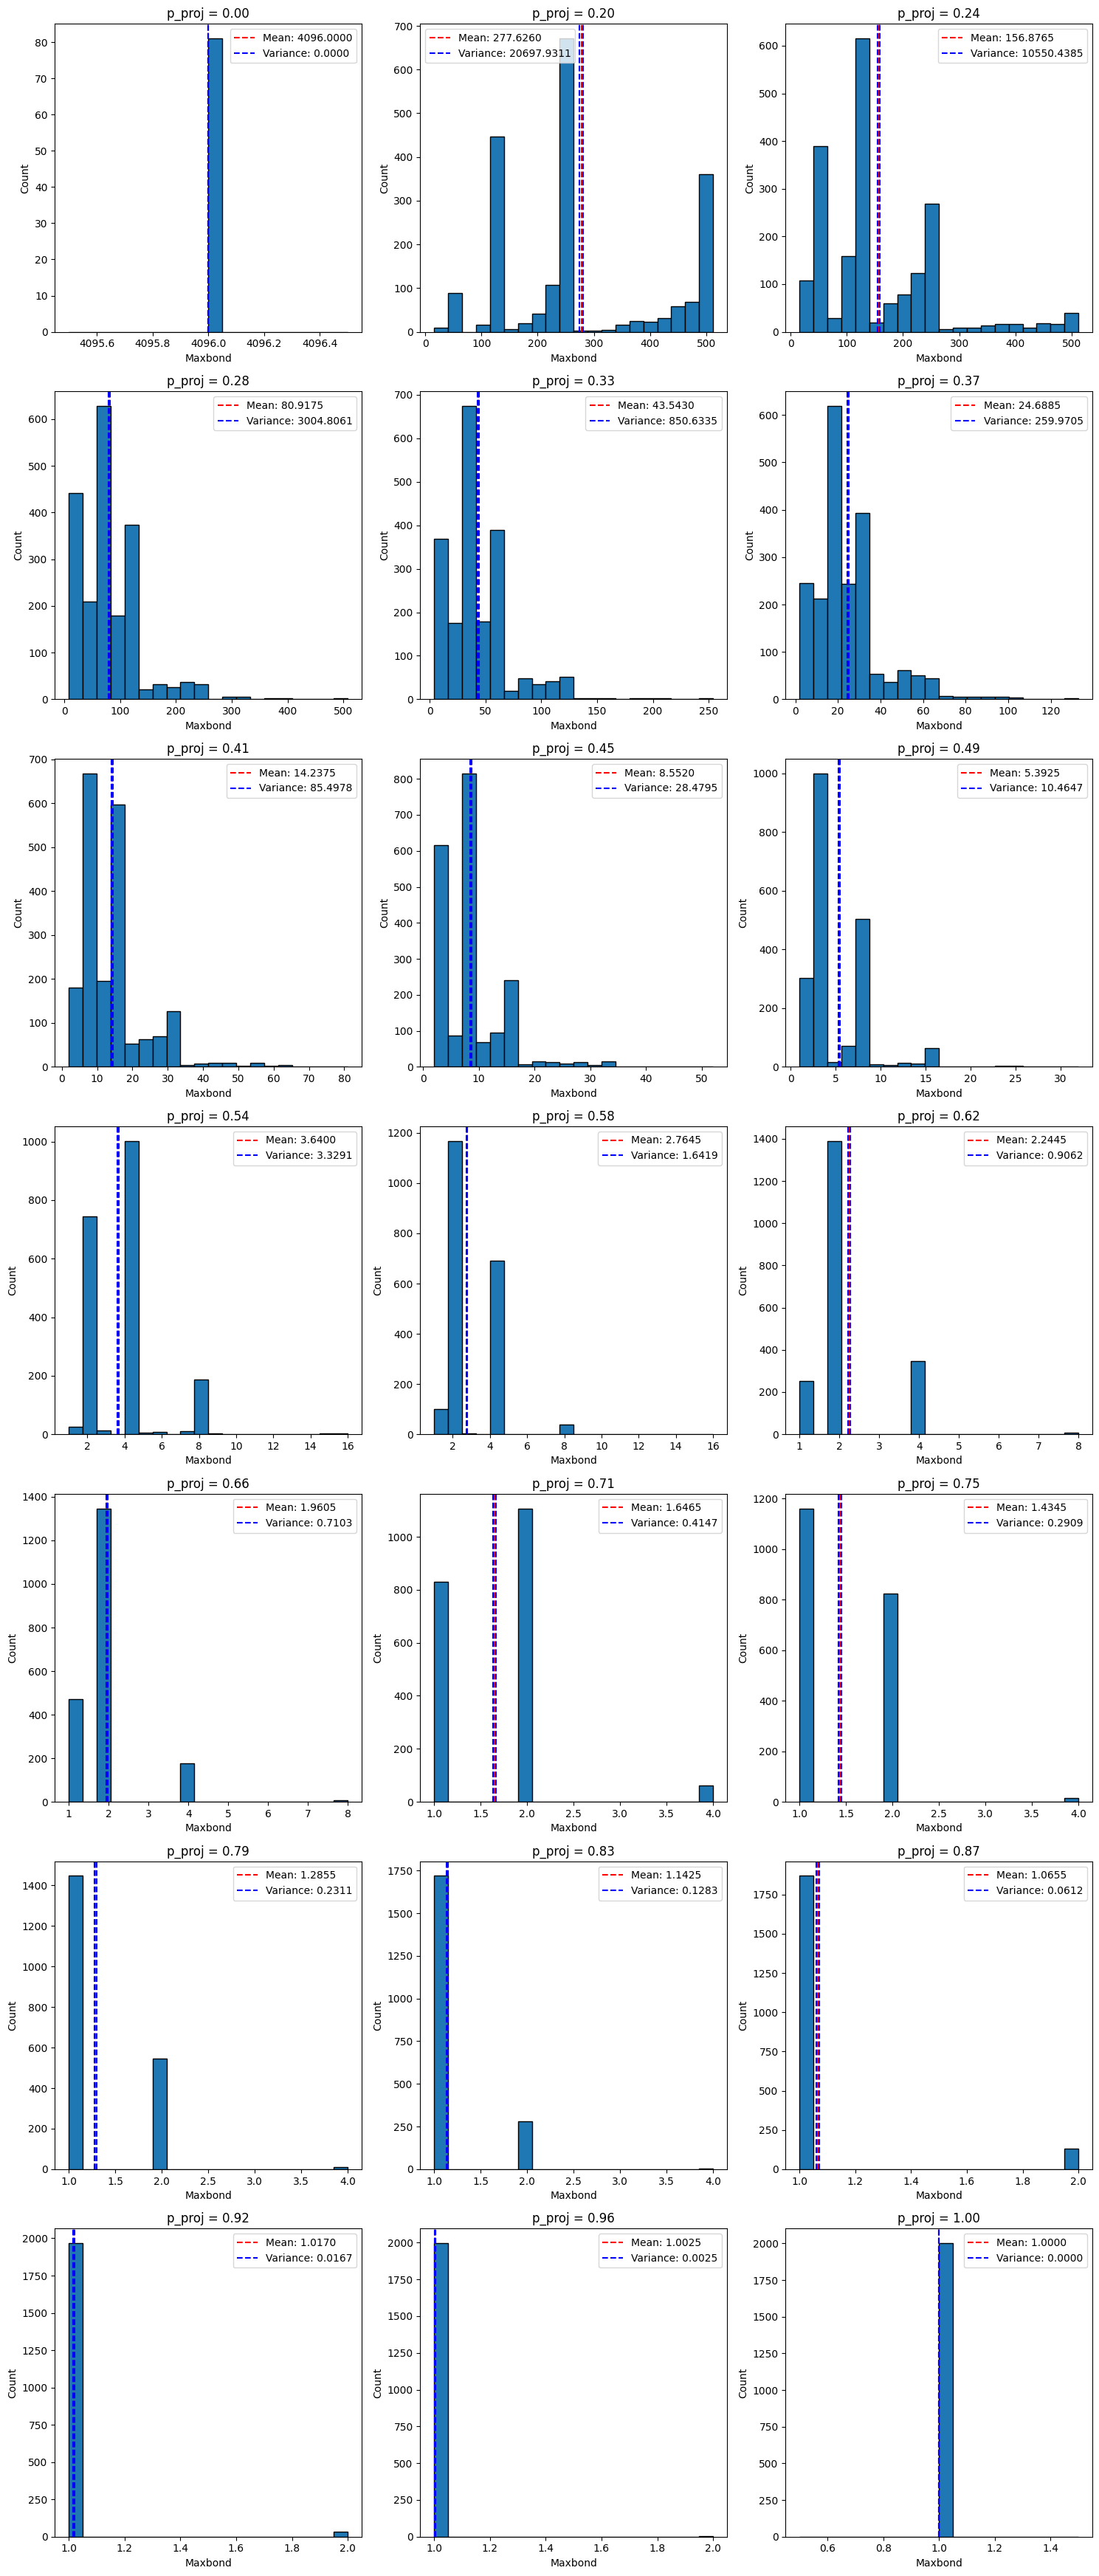

In [ ]:
import matplotlib.pyplot as plt
from read_hdf5_func import calculate_variance_and_error, calculate_mean_and_error

# Create a figure with subplots arranged based on number of p_proj values
n_plots = len(dict_maxbond)
n_cols = 3
n_rows = (n_plots + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
axes = axes.flatten()

# Plot histogram for each p_proj value
for idx, (p_proj, maxbonds) in enumerate(sorted(dict_maxbond.items())):
    ax = axes[idx]
    mean, sem = calculate_mean_and_error(maxbonds)
    var, semvar = calculate_variance_and_error(maxbonds)
    # print(maxbonds)
    ax.hist(maxbonds, bins=20, edgecolor='black')
    ax.set_title(f'p_proj = {p_proj:.2f}')
    ax.set_xlabel('Maxbond')
    ax.set_ylabel('Count')
    ax.axvline(mean, color='red', linestyle='--', label=f'Mean: {mean:.4f}')
    ax.axvline(mean + sem, color='blue', linestyle='--', label=f'Variance: {var:.4f}')
    ax.axvline(mean - sem, color='blue', linestyle='--')
    ax.legend()

# Remove any empty subplots
for idx in range(len(dict), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()


In [ ]:
print(list(dict_maxbond.keys()))
key = list(dict_maxbond.keys())

print(key)
print(dict_maxbond[key])

[np.float64(1.0), np.float64(0.6210526315789474), np.float64(0.5789473684210527), np.float64(0.9578947368421052), np.float64(0.5368421052631579), np.float64(0.49473684210526314), np.float64(0.45263157894736844), np.float64(0.4105263157894737), np.float64(0.3684210526315789), np.float64(0.3263157894736842), np.float64(0.28421052631578947), np.float64(0.24210526315789474), np.float64(0.2), np.float64(0.9157894736842105), np.float64(0.8736842105263158), np.float64(0.8315789473684211), np.float64(0.7894736842105263), np.float64(0.7473684210526316), np.float64(0.7052631578947368), np.float64(0.6631578947368421), np.float64(0.0)]
[np.float64(1.0), np.float64(0.6210526315789474), np.float64(0.5789473684210527), np.float64(0.9578947368421052), np.float64(0.5368421052631579), np.float64(0.49473684210526314), np.float64(0.45263157894736844), np.float64(0.4105263157894737), np.float64(0.3684210526315789), np.float64(0.3263157894736842), np.float64(0.28421052631578947), np.float64(0.24210526315789

TypeError: unhashable type: 'list'

In [ ]:
len(L24_groups)